Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2025-10-26 по 2025-11-01 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Задача — проанализировать данные А/B-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах 
2. Сравнить данные этими тестами, посмотреть на распределения глазами. Почему тесты сработали именно так? 
3. Описать потенциальную ситуацию, когда такое изменение могло произойти
4. Дать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. 

In [29]:
import pandahouse
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [30]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'http://clickhouse.lab.karpov.courses:8123',
'database':'simulator_20251120',
'user':'student',
'password':'dpo_python_2020'
}

In [31]:
# запрос
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20251120.feed_actions 
WHERE toDate(time) between '2025-10-26' and '2025-11-01'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()
# видим, что в 1 группе 10020 пользователей, во 2 - 9877 пользователей

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


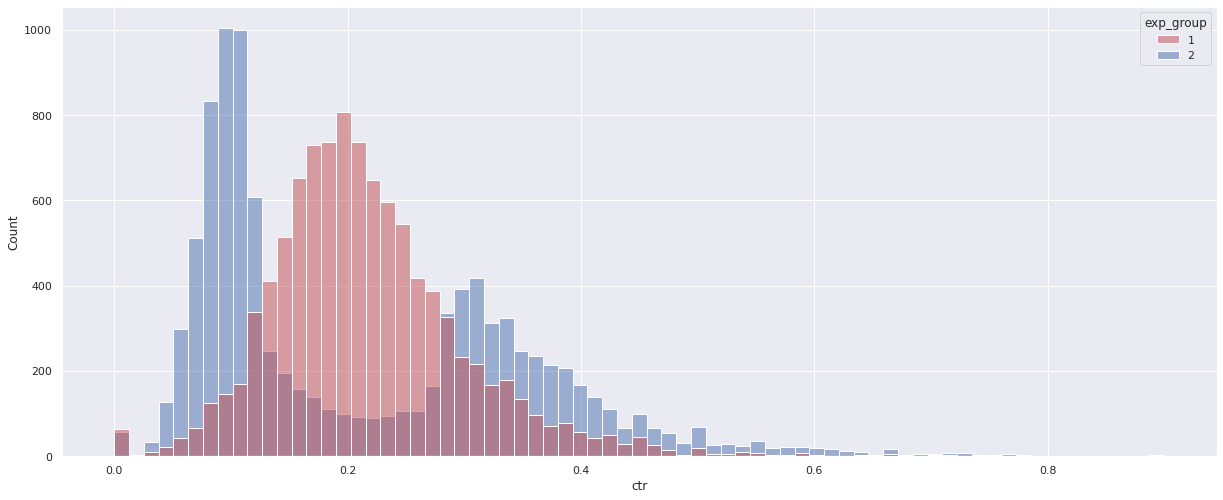

In [32]:
# Распределение CTR по группам
sns.set(rc={'figure.figsize':(20.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
# В первой (контрольной) группе унимодальное распределение, относительно симметричное, похожее на нормальное.
# Во второй группе видим двумодальное распределение, выборка разделилась на тех кому понравилось обновление и ctr вырос
# и тех кому не понравилось и ctr упал

__________

 ## T-критерий Стьюдента

Нулевая гипотеза: средние двух выборок равны

Альтернативная гипотеза: средние двух выборок не равны

In [33]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Мы не отвергаем нулевую гипотезу, поскольку с вероятностью 68% можем получить такие же или более выраженные результаты даже если нулевая гипотеза верна

______________

In [34]:
print("Средний CTR для группы 1:", df[df.exp_group == 1].ctr.mean())
print("Средний CTR для группы 2:", df[df.exp_group == 2].ctr.mean())

Средний CTR для группы 1: 0.216773994120072
Средний CTR для группы 2: 0.2161016893237817


________

## Тест Манна-Уитни

In [36]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

p-value существенно меньше 5% это означает, что распределения существенно различаются

________

## T-тест на сглаженном ctr (α=5)

In [38]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [39]:
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = group1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = group2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

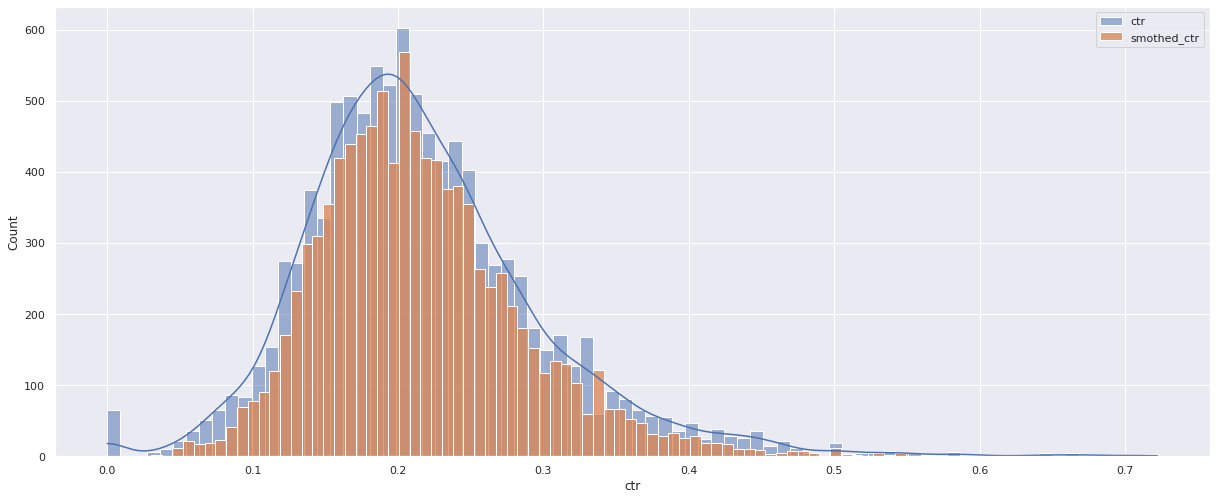

In [40]:
sns.histplot(group1.ctr, 
             kde = True, bins = 80, label = 'ctr')
sns.histplot(group1.smothed_ctr, 
             kde = False, bins = 80, label = 'smothed_ctr')
plt.legend()

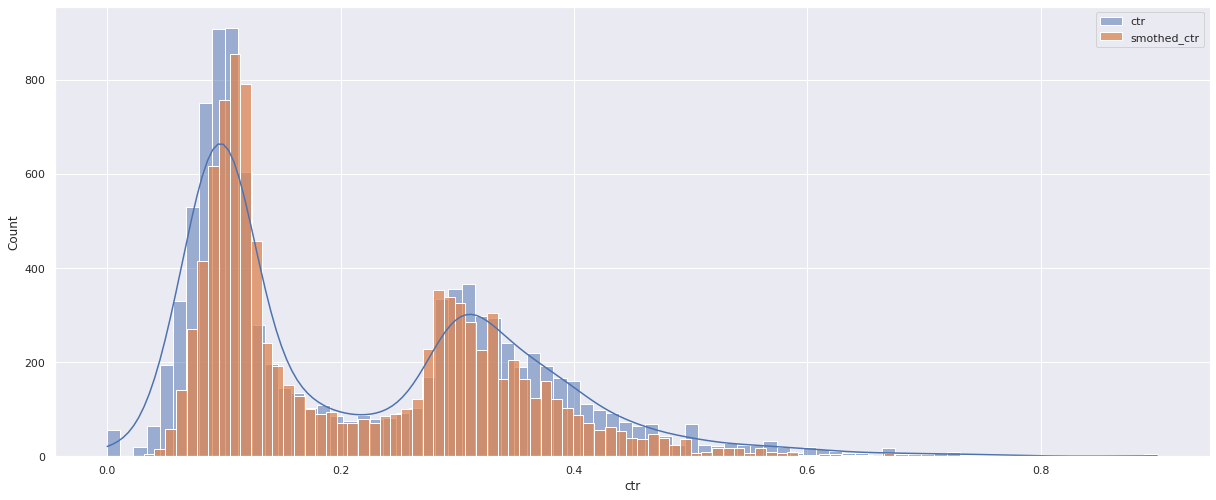

In [41]:
sns.histplot(group2.ctr, 
             kde = True, bins = 80, label = 'ctr')
sns.histplot(group2.smothed_ctr, 
             kde = False, bins = 80, label = 'smothed_ctr')
plt.legend()

In [43]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [44]:
print("Средний smothed CTR для группы 1:", group1.smothed_ctr.mean())
print("Средний smothed CTR для группы 2:", group2.smothed_ctr.mean())

Средний smothed CTR для группы 1: 0.21527988017565183
Средний smothed CTR для группы 2: 0.21250810594606076


Сглаживание привело к изменению средних и их большему различию чем в начальных данных. По результатам теста не отвергаем нулевую гипотезу о равенстве средних. 

_________

### Т.к. нужно оценить общий показатель показатель CTR по всей группе - выбираем бутстреп и бакетное преобразование 
(Можно было сделать только их)

__________

## Пуассоновский бутстреп

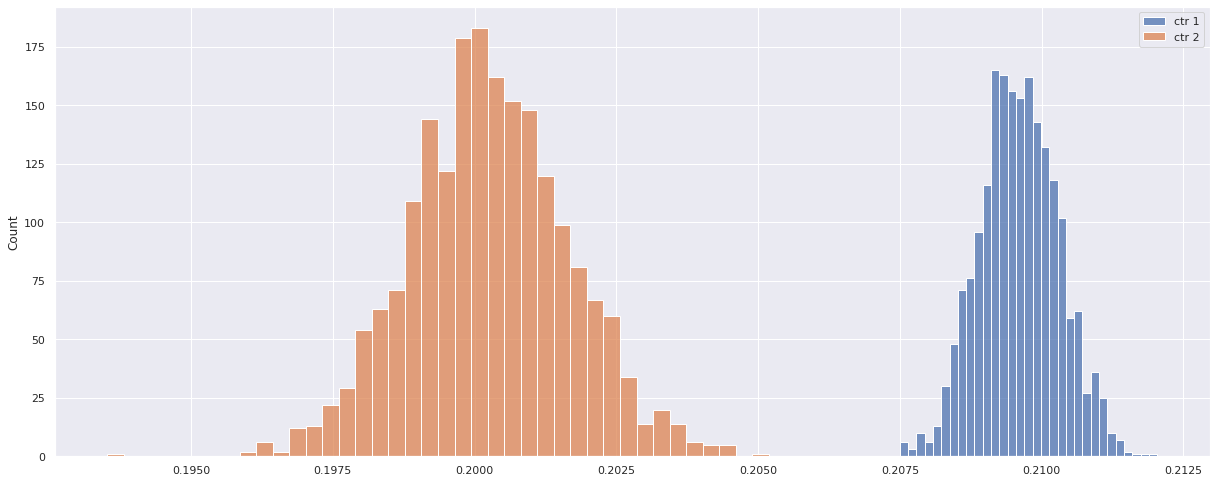

In [22]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, label = 'ctr 1')
sns.histplot(ctr2, label = 'ctr 2')
plt.legend()

<Axes: ylabel='Count'>

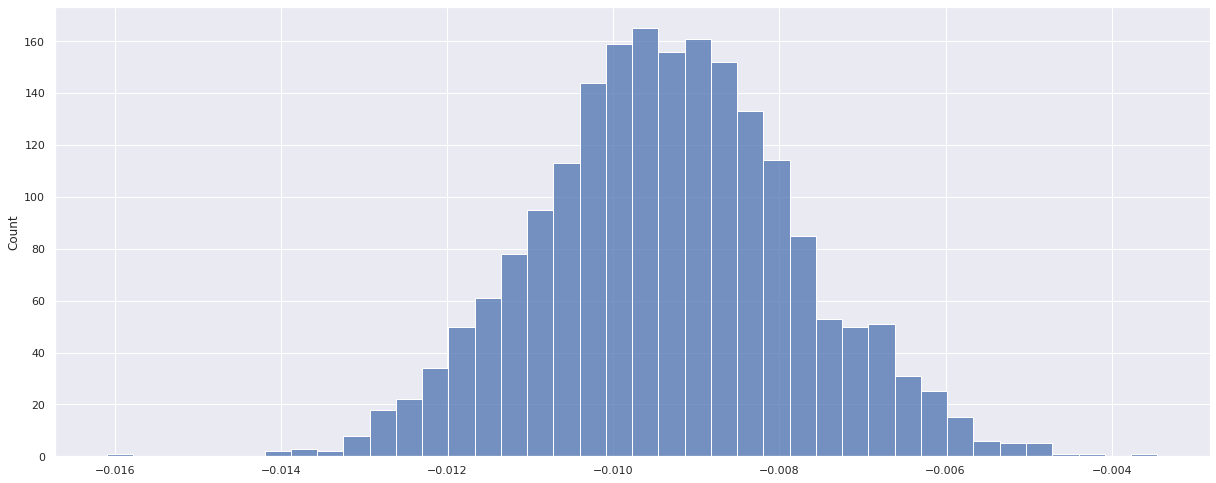

In [23]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)

In [24]:
diff = ctr2 - ctr1  

# p-value: вероятность того, что разность ≤ 0 
p_value = np.mean(diff <= 0)
print("Бутстрап p-value:", p_value)

Бутстрап p-value: 1.0


#### Глобальный ctr второй группы меньше первой

________

## Бакетное преобразование

In [25]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20251120.feed_actions 
    WHERE toDate(time) between '2025-10-26' and '2025-11-01'
    and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [26]:
#и t-тест тоже

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

________

## Выводы

Раскатывать на всех пользователей не стоит, Пуассоновский бутстреп показывает негативное влияние на глобальный CTR. 

Одной части пользователей понравилось обновление, рекомендации стали более релевантными и ctr вырос, другой - нет. Возможно стоит попытаться понять кому и почему зашло обновление, а кому и почему - нет, и исходя из этого предложить новое обновление, учитывающее это.